In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import Sequential, Conv2d, LeakyReLU, MaxPool2d, AdaptiveAvgPool2d, Linear, Dropout, Flatten
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from classes.CNN_pytorch import YoloDataset, YoloLoss, YOLOv1, CNN_model, YOLO_visual #import my class CNN

In [2]:
S = 7
B = 2
C = 20

In [3]:
df_encoded = torch.load(r"data\encoded_picture.pt",weights_only=False)
df_encoded

,file_name,encoded_grid
1,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
2,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
3,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
4,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
5,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
...,...,...
13295,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
13296,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
13297,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
13298,C:\Users\Lucas\Desktop\vacantion classes\Yolo ...,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded['file_name'],df_encoded['encoded_grid'],test_size=0.4)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
X_train = X_train[:1000]
y_train = y_train[:1000]

In [6]:
train_dataset = YoloDataset(X_train, y_train)
test_dataset = YoloDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [7]:
train_dataset[76][1][1]

c:\Users\Lucas\Desktop\vacantion classes\Yolo project\classes\CNN_pytorch.py:533: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.Y_tensor[idx], dtype=torch.float32)


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]])

In [8]:
def show_yolo_label(img_tensor, label_tensor, img_size=448, conf_threshold=0.5):
    # Convert tensor to numpy and back to OpenCV format (HWC)
    img = img_tensor.permute(1, 2, 0).numpy()
    img = (img * 255).astype('uint8')
    img = img[..., ::-1].copy()  # RGB -> BGR for OpenCV
    
    # If label is YOLO-style grid (SxSxBx5)
    if label_tensor.ndim == 3:
        S = label_tensor.shape[0]
        for i in range(S):
            for j in range(S):
                cell = label_tensor[i, j]
                if cell[0] > conf_threshold:  # confidence score
                    x, y, w, h = cell[1:5]
                    # Convert to absolute coords
                    x_center = (j + x) / S * img_size
                    y_center = (i + y) / S * img_size
                    w_pixel = w * img_size
                    h_pixel = h * img_size
                    x1 = int(x_center - w_pixel / 2)
                    y1 = int(y_center - h_pixel / 2)
                    x2 = int(x_center + w_pixel / 2)
                    y2 = int(y_center + h_pixel / 2)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    else:
        # Assume label is [class, x, y, w, h] or [x, y, w, h]
        boxes = label_tensor.view(-1, 5 if label_tensor.shape[-1] == 5 else 4)
        for box in boxes:
            if box.numel() == 5:
                _, x, y, w, h = box
            else:
                x, y, w, h = box
            x1 = int((x - w/2) * img_size)
            y1 = int((y - h/2) * img_size)
            x2 = int((x + w/2) * img_size)
            y2 = int((y + h/2) * img_size)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Show image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


c:\Users\Lucas\Desktop\vacantion classes\Yolo project\classes\CNN_pytorch.py:533: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.Y_tensor[idx], dtype=torch.float32)


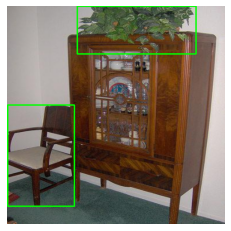

In [15]:
img, label = train_dataset[12]
show_yolo_label(img, label)


### Corrected visualization function

In [16]:
pred_tensor = train_dataset[12][1]
img_path = X_train[12]

viz = YOLO_visual(S=7, B=2, C=20, classes=[i for i in range(20)])
viz.display_yolo_predictions(pred_tensor,img_path,score_threshold=0.001)

[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
[0.04604416 0.04604416 0.04604416 0.04604416 0.04604416 0.04604416
 0.04604416 0.04604416 0.04604416 0.04604416 0.04604416 0.04604416
 0.04604416 0.04604416 0.04604416 0.04604416 0.04604416 0.04604416
 0.125161   0.04604416]
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
[0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.0

Exam ursu : 
classifier,
les algo genetique,
pas de question trop theorique en dehors du meilleur regresseur, meilleur classifieur,


In [11]:
img_path = X_train[0] 
img = cv2.imread(img_path)
img = cv2.resize(img, (448, 448))
print(img.shape)

(448, 448, 3)


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
S, B, C = 7, 2, 20

model = YOLOv1(S=S, B=B, C=C).to(device)
criterion = YoloLoss(S=S, B=B, C=C)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

loaded_model = YOLOv1(S=S, B=B, C=C).to(device)
loaded_model.load_state_dict(torch.load("yolov1_trained.pth", map_location=device))
loaded_model.eval()
print("🔁 Loaded model from yolov1_trained.pth")


🔁 Loaded model from yolov1_trained.pth


In [13]:
def bbox_coordinate_format(bbox):
    img_width, img_height = 448, 448

    _,x,y,w,h=bbox

    x_center = x * img_width
    y_center = y * img_height
    box_width = w * img_width
    box_height = h * img_height

    x1 = x_center - box_width / 2
    y1 = y_center - box_height / 2
    x2 = x_center + box_width / 2
    y2 = y_center + box_height / 2

    return x1.item(),y1.item(),x2.item(),y2.item()


In [17]:
def iou(bbox_predicted,bbox_actual):

    x_min_predicted,y_min_predicted,x_max_predicted,y_max_predicted=bbox_coordinate_format(bbox_predicted)
    x_min_actual,y_min_actual,x_max_actual,y_max_actual=bbox_coordinate_format(bbox_actual)

    x_intersection_right=min(x_max_actual,x_max_predicted)
    x_intersection_left=max(x_min_actual,x_min_predicted)
    y_intersection_lower=min(y_max_actual,y_max_predicted)
    y_intersection_upper=max(y_min_actual,y_min_predicted)

    w_inter=max(0,x_intersection_right-x_intersection_left)
    h_inter=max(0,y_intersection_lower-y_intersection_upper)

    w_box1=max(0,x_max_predicted-x_min_predicted)
    h_box1=max(0,y_max_predicted-y_min_predicted)

    w_box2=max(0,x_max_actual-x_min_actual)
    h_box2=max(0,y_max_actual-y_min_actual)

    area_box1=w_box1*h_box1

    area_box2=w_box2*h_box2
            
    area_inter=w_inter*h_inter

    area_union=area_box1+area_box2-area_inter

    if area_union==0:
        return 0
    else:
        iou=area_inter/area_union
        return iou

In [18]:
def yolo_loss(pred, target, l_obj, l_nobj):
    tot_loss = 0
    for img_ind in range(len(pred)):
        for i in range(S):
            for j in range(S):
                boxes = []
                for bbox in range(B):
                    boxes.append(pred[img_ind,i,j,bbox*5:(bbox+1)*5])

                true_box = target[img_ind,i,j,0:5]
                best_box_ind = np.argmax([iou(box,true_box) for box in boxes])
                best_box = boxes[best_box_ind]

                if true_box[0]==1:
                    pred_conf = torch.sigmoid(pred[img_ind,i,j,B*5:])
                    xy_loss = torch.sum((best_box[1:3] - true_box[1:3]) ** 2)
                    wh_loss = torch.sum((torch.sqrt(torch.abs(best_box[3:5] + 1e-6)) - torch.sqrt(torch.abs(true_box[3:5] + 1e-6))) ** 2)
                    conf_loss_obj = torch.sum((pred_conf - target[img_ind,i,j,5:]) ** 2)
                    class_loss = torch.sum((best_box[0] - true_box[0]) ** 2)
                    tot_loss += l_obj * (xy_loss+wh_loss) + class_loss + conf_loss_obj
                else: 
                    class_loss = torch.sum((best_box[0] - true_box[0]) ** 2)
                    tot_loss += l_nobj * class_loss 

    return tot_loss

In [19]:
pred = torch.rand((100,S,S,B*5+C))
target = torch.rand((100,S,S,5+C))

In [20]:
loss = yolo_loss(pred,target,5,0.5)

In [21]:
loss_fn = YoloLoss()

# perfect match (IoU should be 1.0)
box_pred = torch.tensor([1, 0.5, 0.5, 0.2, 0.2])
box_true = torch.tensor([1, 0.5, 0.5, 0.2, 0.2])

print(loss_fn.iou(box_pred, box_true))


tensor(0.0813)


In [22]:
def iou(box1, box2):
    # box: [conf, x, y, w, h] with x,y,w,h in normalized coordinates

    # Extract values
    _, x1, y1, w1, h1 = box1
    _, x2, y2, w2, h2 = box2

    # YOLOv1 predicts sqrt(w), sqrt(h) — but your target is already w,h normalisés
    w1 = w1 ** 2
    h1 = h1 ** 2
    w2 = w2 ** 2
    h2 = h2 ** 2

    # Convert to corners
    box1_x1 = x1 - w1 / 2
    box1_y1 = y1 - h1 / 2
    box1_x2 = x1 + w1 / 2
    box1_y2 = y1 + h1 / 2

    box2_x1 = x2 - w2 / 2
    box2_y1 = y2 - h2 / 2
    box2_x2 = x2 + w2 / 2
    box2_y2 = y2 + h2 / 2

    # Intersection
    inter_x1 = torch.max(box1_x1, box2_x1)
    inter_y1 = torch.max(box1_y1, box2_y1)
    inter_x2 = torch.min(box1_x2, box2_x2)
    inter_y2 = torch.min(box1_y2, box2_y2)

    inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * \
                 torch.clamp(inter_y2 - inter_y1, min=0)

    area1 = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    area2 = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)

    return inter_area / (area1 + area2 - inter_area + 1e-6)

In [23]:
iou(box_pred,box_true)

tensor(0.9994)

In [24]:
pred = torch.zeros((1, 7, 7, 30))  # If B=2,C=20 => B*5 + C = 10 + 20 = 30
target = torch.zeros((1, 7, 7, 25))

# Put a single object in cell (3,3)
target[0,3,3,0] = 1            # object exists
target[0,3,3,1:5] = torch.tensor([0.5, 0.5, 0.2, 0.2])  # bbox (x,y,w,h)
target[0,3,3,5+3] = 1          # class index 3 = one-hot

loss_fn = YoloLoss()
print(loss_fn.yolo_loss(pred, target))


tensor(15.1911)
